<a href="https://colab.research.google.com/github/digitalhumanitiestextbook/dhtextbook/blob/main/chapter08/8_sentiment_analysis.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# 데이터셋 다운로드를 위한 라이브러리 설치
!pip install requests

In [1]:
# 데이터셋 초기화
import os
import requests

# input, output 폴더 검증
for folder in ["input", "output"]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# 파일 경로와 다운로드 링크
file_path = os.path.join("input", "sonnets_sentiment_scores.xlsx")
url = "https://raw.githubusercontent.com/digitalhumanitiestextbook/dhtextbook/c26213272c77aaac58e2a0e407380106d7db5205/chapter08/input/sonnets_sentiment_scores.xlsx"

# quotation_info.csv 파일이 없으면 다운로드
if not os.path.exists(file_path):
    response = requests.get(url)
    response.raise_for_status()  # 오류 발생시 예외처리
    with open(file_path, "wb") as f:
        f.write(response.content)
    print(f"다운로드 완료: {file_path}")
else:
    print(f"이미 존재함: {file_path}")

다운로드 완료: input/sonnets_sentiment_scores.xlsx


In [2]:
# NLTK, VADER 설치
!pip install nltk
!pip install vaderSentiment
!python -m nltk.downloader vader_lexicon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
# VADER를 활용한 감정 분석
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 감정 분석 예시 텍스트
text1 = "I am happy."
text2 = "I am not unhappy."
text3 = "Today is Wednesday."
text4 = "I was very saddened by the news."

# SentimentIntensityAnalyzer 초기화
sid = SentimentIntensityAnalyzer()

# 각 텍스트에 대한 감정 점수 계산
text1_sentiment = sid.polarity_scores(text1)
text2_sentiment = sid.polarity_scores(text2)
text3_sentiment = sid.polarity_scores(text3)
text4_sentiment = sid.polarity_scores(text4)

# 결과 출력
print(text1, ':', text1_sentiment)
print(text2, ':', text2_sentiment)
print(text3, ':', text3_sentiment)
print(text4, ':', text4_sentiment)

I am happy. : {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
I am not unhappy. : {'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'compound': 0.3252}
Today is Wednesday. : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
I was very saddened by the news. : {'neg': 0.425, 'neu': 0.575, 'pos': 0.0, 'compound': -0.5709}


In [4]:
# RoBERTa 기반 모델을 활용한 감정 분석
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import pandas as pd
from scipy.special import softmax

# 사용할 사전학습 감정분석 모델 이름 지정
MODEL = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

# 토크나이저(문장 → 토큰)와 모델(감정분류) 불러오기
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# 하나의 문장에 대해 감정 점수를 반환하는 함수
def sentimentanalyzer(sent):
    encoded_input = tokenizer(sent, return_tensors='pt')  # 문장 토큰화 및 텐서 변환
    output = model(**encoded_input)  # 모델에 입력해서 결과 얻기
    score = output[0][0].detach().numpy()  # 결과에서 점수 추출 (Tensor → numpy)
    score = softmax(score)  # 소프트맥스 함수를 적용하여 확률로 변환

    # 점수를 각 감정(label)에 매핑
    return pd.Series(score, index=['negative', 'neutral', 'positive'])

# 여러 문장에 대해 감정 분석하는 함수
def analyze_sentiments(*texts):
    sentiment_results = {}

    # 각 텍스트에 대해 감정 분석 수행
    for text in texts:
        sentiment_results[text] = sentimentanalyzer(text)

    sentiment_indexes = {}

    for text, scores in sentiment_results.items():
        sentiment_index = scores['positive'] - scores['negative']  # positive - negative 값을 sentiment index로 정의
        # 감정 점수와 인덱스를 딕셔너리에 저장
        sentiment_indexes[text] = {
            'scores': scores,
            'sentiment_index': sentiment_index
        }

    return sentiment_indexes

# 예시 텍스트에 대한 감정 분석
results = analyze_sentiments(text1, text2, text3, text4)

# 결과 출력
for text, result in results.items():
    print(f'Text: {text}\nSentiment Scores:\n{result["scores"]}\nSentiment Score: {result["sentiment_index"]}\n')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Text: I am happy.
Sentiment Scores:
negative    0.005942
neutral     0.025205
positive    0.968853
dtype: float32
Sentiment Score: 0.9629109501838684

Text: I am not unhappy.
Sentiment Scores:
negative    0.104478
neutral     0.472562
positive    0.422961
dtype: float32
Sentiment Score: 0.31848305463790894

Text: Today is Wednesday.
Sentiment Scores:
negative    0.011078
neutral     0.746358
positive    0.242564
dtype: float32
Sentiment Score: 0.23148564994335175

Text: I was very saddened by the news.
Sentiment Scores:
negative    0.872881
neutral     0.115741
positive    0.011379
dtype: float32
Sentiment Score: -0.8615016937255859



In [5]:
# RoBERTa 기반 모델을 활용한 감정분석(<변신>)
import nltk
from nltk.tokenize import sent_tokenize

# NLTK의 영어 문장 토큰화 도구 다운로드
nltk.download('punkt')
nltk.download('punkt_tab')

# 감정 분석 예시로 사용할 영문 텍스트(카프카 <변신> 첫 부분)
passage = """
One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.
He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.
The bedding was hardly able to cover it and seemed ready to slide off any moment.
His many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked.
“What’s happened to me?” he thought. It wasn’t a dream. His room, a proper human room although a little too small, lay peacefully between its four familiar walls.
A collection of textile samples lay spread out on the table—Samsa was a travelling salesman—and above it there hung a picture that he had recently cut out of an illustrated magazine and housed in a nice, gilded frame.
It showed a lady fitted out with a fur hat and fur boa who sat upright, raising a heavy fur muff that covered the whole of her lower arm towards the viewer.
"""

# 긴 passage를 문장 단위로 분할
sentences = sent_tokenize(passage)

# 여러 문장에 대해 감정분석 실행 (위에서 사용하였던 분석 함수 재사용)
results = analyze_sentiments(*sentences)

# 결과를 문장별로 출력
for sentence, result in results.items():
    print(f'Sentence: "{sentence}"\nSentiment Scores:\n{result["scores"]}\nSentiment Score: {result["sentiment_index"]}\n')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Sentence: "
One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin."
Sentiment Scores:
negative    0.846908
neutral     0.147000
positive    0.006092
dtype: float32
Sentiment Score: -0.8408160209655762

Sentence: "He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections."
Sentiment Scores:
negative    0.019569
neutral     0.907486
positive    0.072945
dtype: float32
Sentiment Score: 0.053376104682683945

Sentence: "The bedding was hardly able to cover it and seemed ready to slide off any moment."
Sentiment Scores:
negative    0.731410
neutral     0.252737
positive    0.015853
dtype: float32
Sentiment Score: -0.715556800365448

Sentence: "His many legs, pitifully thin compared with the size of the rest of him, waved about helplessly as he looked."
Sentiment Scores:
negative    0.792066
neutral     0.189513
positive    0.018422

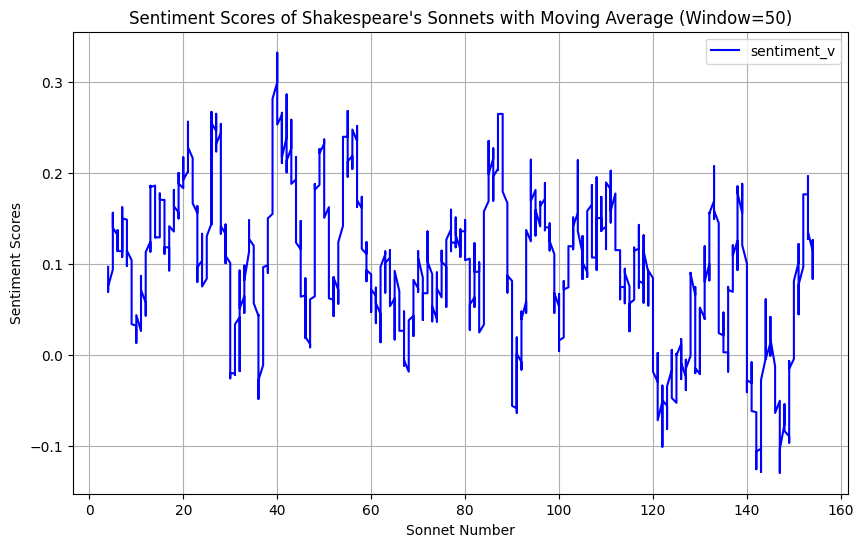

In [6]:
# 셰익스피어 소네트의 감정 분석 결과(sentiment_v)를 곡선으로 시각화하기 (단순이동평균의 윈도우=50)
import pandas as pd
import matplotlib.pyplot as plt

file_path = "input/sonnets_sentiment_scores.xlsx"  # 엑셀 파일 경로 지정
data = pd.read_excel(file_path)  # 엑셀 파일에서 데이터 읽기

# 소네트 번호와 감정 점수 컬럼 추출
sonnet_numbers = data ['Sonnet']  # 소네트 번호
sentiment_scores_v = data ['sentiment_v']  # 감정 점수(v)
moving_avg_v = sentiment_scores_v.rolling(window=50).mean()  # 윈도우 값에 따라 window 이후의 숫자 조정

plt.figure(figsize=(10, 6))  # 그래프 크기 지정
plt.plot(sonnet_numbers, moving_avg_v, label='sentiment_v', linestyle='-', marker='', color='blue')  # 이동평균 곡선 그리기
plt.title('Sentiment Scores of Shakespeare\'s Sonnets with Moving Average (Window=50)')  # 그래프 제목 설정
plt.xlabel('Sonnet Number')  # x축 레이블 설정
plt.ylabel('Sentiment Scores')  # y축 레이블 설정
plt.legend()  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 출력

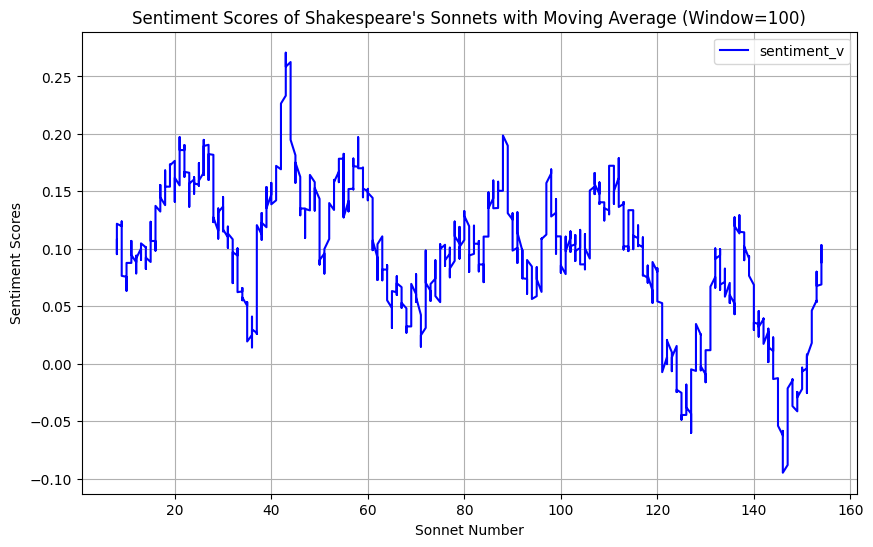

In [7]:
# 셰익스피어 소네트의 감정 분석 결과(sentiment_v)를 곡선으로 시각화하기
# 이동평균의 윈도우=100
moving_avg_v = sentiment_scores_v.rolling(window=100).mean() # 윈도우 값에 따라 window 이후의 숫자 조정

plt.figure(figsize=(10, 6))  # 그래프 크기 지정
plt.plot(sonnet_numbers, moving_avg_v, label='sentiment_v', linestyle='-', marker='', color='blue')  # 이동평균 곡선 그리기
plt.title('Sentiment Scores of Shakespeare\'s Sonnets with Moving Average (Window=100)')  # 그래프 제목 설정
plt.xlabel('Sonnet Number')  # x축 레이블 설정
plt.ylabel('Sentiment Scores')  # y축 레이블 설정
plt.legend()  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 출력

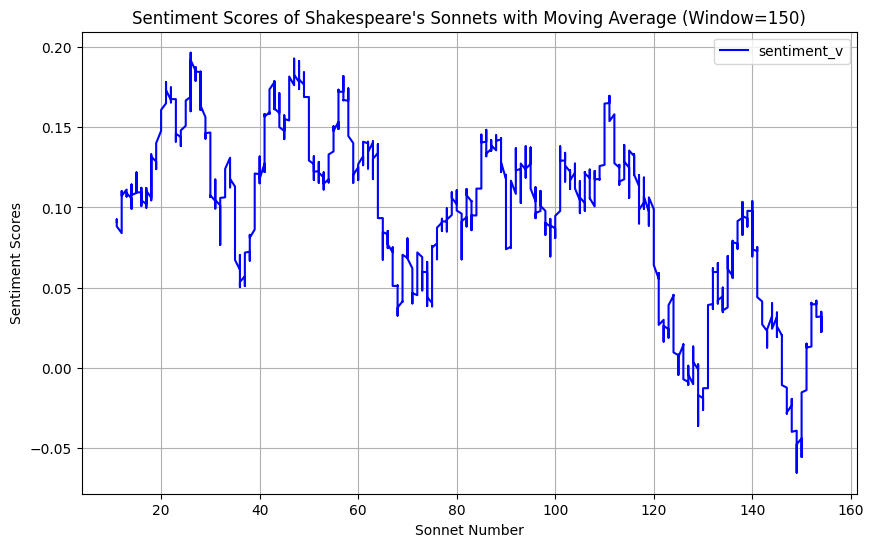

In [8]:
# 셰익스피어 소네트의 감정 분석 결과(sentiment_v)를 곡선으로 시각화하기
# 이동평균의 윈도우=150
moving_avg_v = sentiment_scores_v.rolling(window=150).mean() # 윈도우 값에 따라 window 이후의 숫자 조정

plt.figure(figsize=(10, 6))  # 그래프 크기 지정
plt.plot(sonnet_numbers, moving_avg_v, label='sentiment_v', linestyle='-', marker='', color='blue')  # 이동평균 곡선 그리기
plt.title('Sentiment Scores of Shakespeare\'s Sonnets with Moving Average (Window=150)')  # 그래프 제목 설정
plt.xlabel('Sonnet Number')  # x축 레이블 설정
plt.ylabel('Sentiment Scores')  # y축 레이블 설정
plt.legend()  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 출력

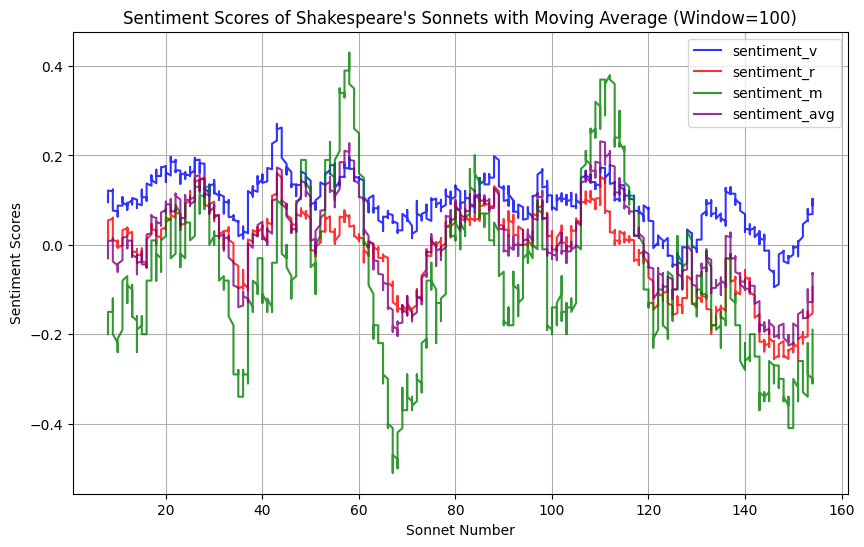

In [9]:
# 셰익스피어 소네트의 감정 분석 결과 전체를 곡선으로 시각화하기
# 이동평균의 윈도우=100
sentiments = ['sentiment_v', 'sentiment_r', 'sentiment_m', 'sentiment_avg']
colors = ['blue', 'red', 'green', 'purple']

plt.figure(figsize=(10, 6))  # 그래프 크기 지정

# 각 감정 지표별로 이동평균을 계산해서 곡선 그리기
for sentiment, color in zip(sentiments, colors):
    moving_avg = data[sentiment].rolling(window=100).mean()   # 이동평균(윈도우=100) 계산
    plt.plot(data['Sonnet'], moving_avg, label=sentiment, linestyle='-', color=color, alpha=0.8)  # 소네트 번호에 대해 곡선 그리기

plt.title('Sentiment Scores of Shakespeare\'s Sonnets with Moving Average (Window=100)')  # 그래프 제목 설정
plt.xlabel('Sonnet Number')  # x축 레이블 설정
plt.ylabel('Sentiment Scores')  # y축 레이블 설정
plt.legend()  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 출력

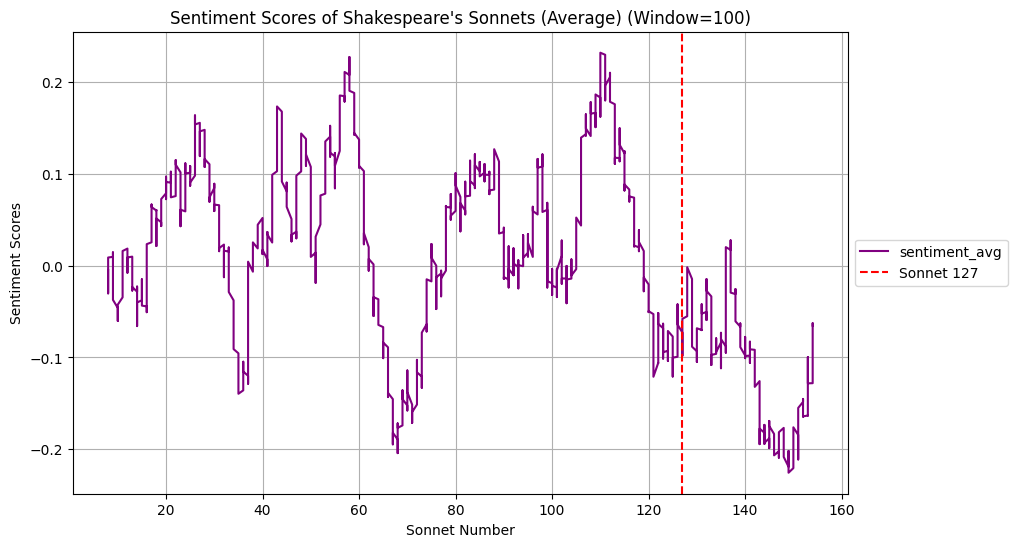

In [10]:
# 셰익스피어 소네트의 감정 분석 결과 중 평균을 곡선으로 시각화하고 주요 지점 표시하기
# 이동평균의 윈도우=100
sentiment_scores_average = data['sentiment_avg']
moving_avg_average = sentiment_scores_average.rolling(window=100).mean()

plt.figure(figsize=(10, 6))  # 그래프 크기 지정
plt.plot(sonnet_numbers, moving_avg_average, label='sentiment_avg', linestyle='-', color='purple')  # 이동평균 곡선 그리기
plt.axvline(x=127, color='r', linestyle='--', label='Sonnet 127') # 127번 소네트의 위치를 빨간 점선으로 표시

plt.title('Sentiment Scores of Shakespeare\'s Sonnets (Average) (Window=100)')  # 그래프 제목 설정
plt.xlabel('Sonnet Number')  # x축 레이블 설정
plt.ylabel('Sentiment Scores')  # y축 레이블 설정
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 출력

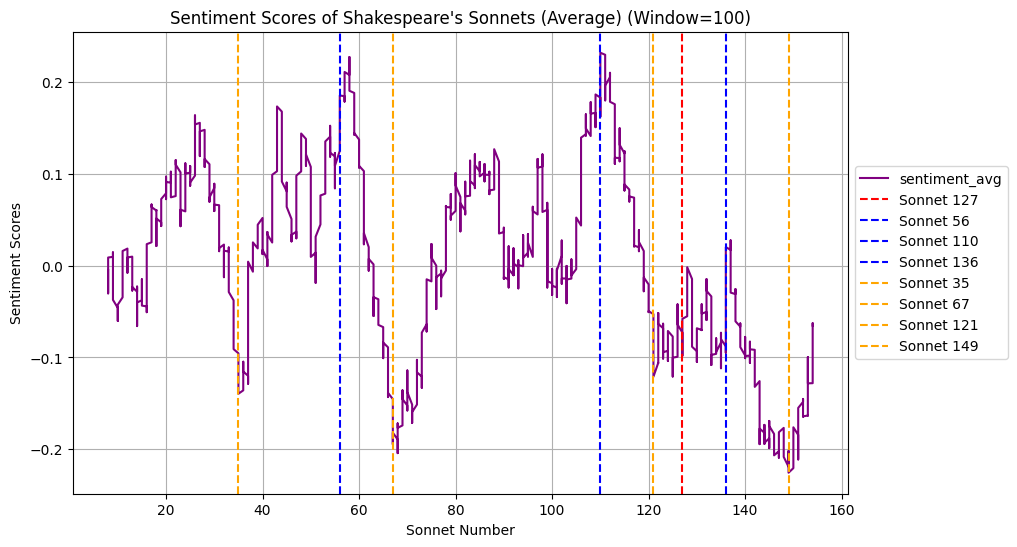

In [11]:
# 셰익스피어 소네트의 감정 분석 결과 중 평균을 곡선으로 시각화하고 곡선의 고점 및 저점 표시하기
# 이동평균의 윈도우=100
plt.figure(figsize=(10, 6))  # 그래프 크기 지정
plt.plot(sonnet_numbers, moving_avg_average, label='sentiment_avg', linestyle='-', color='purple')  # 이동평균 곡선 그리기
plt.axvline(x=127, color='r', linestyle='--', label='Sonnet 127')  # 127번 소네트의 위치를 빨간 점선으로 표시

# 곡선의 고점을 파란 점선으로 표시하기
sonnets_high_points = [56, 110, 136]
for sonnet_number in sonnets_high_points:
    plt.axvline(x=sonnet_number, color='blue', linestyle='--', label=f'Sonnet {sonnet_number}')

# 곡선의 저점을 주황 점선으로 표시하기
sonnets_low_points = [35, 67, 121, 149]
for sonnet_number in sonnets_low_points:
    plt.axvline(x=sonnet_number, color='orange', linestyle='--', label=f'Sonnet {sonnet_number}')

plt.title('Sentiment Scores of Shakespeare\'s Sonnets (Average) (Window=100)')  # 그래프 제목 설정
plt.xlabel('Sonnet Number')  # x축 레이블 설정
plt.ylabel('Sentiment Scores')  # y축 레이블 설정
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # 범례 표시
plt.grid(True)  # 그리드 표시
plt.show()  # 그래프 출력